# Nonlinear Program (NLP) Tutorial
For instructions on how to run these tutorial notebooks, please see the [index](./index.ipynb).

## Important Note
Please refer to the [MathematicalProgram Tutorial](./mathematical_program.ipynb) for constructing and solving a general optimization program in Drake.

## Nonlinear Program
A Nonlinear Programming (NLP) problem is a special type of optimization problem. The cost and/or constraints in an NLP are nonlinear functions of decision variables. The mathematical formulation of a general NLP is

$\begin{aligned} \min_x&\; f(x)\\ \text{subject to }& g_i(x)\leq 0 \end{aligned}$

where $f(x)$ is the cost function, and $g_i(x)$ is the i'th constraint.

An NLP is typically solved through gradient-based optimization (like gradient descent, SQP, interior point methods, etc). These methods rely on the gradient of the cost/constraints $\partial f/\partial x, \partial g_i/\partial x$. pydrake can compute the gradient of many functions through automatic differentiation, so very often the user doesn't need to manually provide the gradient.

## Setting the objective
The user can call `AddCost` function to add a nonlinear cost into the program. Note that the user can call `AddCost` repeatedly, and the program will evaluate the *summation* of each individual cost as the total cost.

### Adding a cost through a python function
We can define a cost through a python function, and then add this python function to the objective through `AddCost` function. When adding a cost, we should provide the variable associated with that cost, the syntax is `AddCost(cost_evaluator, vars=associated_variables)`, which means the cost is evaluated on the `associated_variables`.In the code example below, We first demonstrate how to construct an optimization program with 3 decision variables, then we show how to add a cost through a python function.

In [ ]:
from pydrake.solvers import MathematicalProgram, Solve
import numpy as np

# Create an empty MathematicalProgram named prog (with no decision variables,
# constraints or costs)
prog = MathematicalProgram()
# Add three decision variables x[0], x[1], x[2]
x = prog.NewContinuousVariables(3, "x")

In [ ]:
def cost_fun(z):
    cos_z = np.cos(z[0] + z[1])
    sin_z = np.sin(z[0] + z[1])
    return cos_z**2 + cos_z + sin_z
# Add the cost evaluated with x[0] and x[1].
cost1 = prog.AddCost(cost_fun, vars=[x[0], x[1]])
print(cost1)

PyFunctionCost with 2 decision variables x(0) x(1)



Notice that by changing the argument `vars` in `AddCost` function, we can add the cost to a different set of variables. In the code example below, we use the same python function `cost_fun`, but impose this cost on the variable `x[0], x[2]`.

In [ ]:
cost2 = prog.AddCost(cost_fun, vars=[x[0], x[2]])
print(cost2)

PyFunctionCost with 2 decision variables x(0) x(2)



### Adding cost through a lambda function
A more compact approach to add a cost is through a lambda function. For example, the code below adds a cost $x[1]^2 + x[0]$ to the optimization program.

In [ ]:
# Add a cost x[1]**2 + x[0] using a lambda function.
cost3 = prog.AddCost(lambda z: z[0]**2 + z[1], vars = [x[1], x[0]])
print(cost3)

PyFunctionCost with 2 decision variables x(1) x(0)



If we change the associated variables, then it represents a different cost. For example, we can use the same lambda function, but add the cost $x[1]^2 + x[2]$ to the program by changing the argument to `vars`

In [ ]:
cost4 = prog.AddCost(lambda z: z[0]**2 + z[1], vars = x[1:])
print(cost4)

PyFunctionCost with 2 decision variables x(1) x(2)



## Adding quadratic cost
In NLP, adding a quadratic cost $0.5x^TQx+ b'x+c$ is very common. pydrake provides multiple functions to add quadratic cost, including
- `AddQuadraticCost`
- `AddQuadraticErrorCost`
- `Add2NormSquaredCost`

### AddQuadraticCost
We can add a simple quadratic expression as a cost.

In [ ]:
cost4 = prog.AddQuadraticCost(x[0]**2 + 3 * x[1]**2 + 2*x[0]*x[1] + 2*x[1] * x[0] + 1)
print(cost4)

QuadraticCost (1 + (x(0) * (x(0) + 2 * x(1))) + (x(1) * (2 * x(0) + 3 * x(1))))


If the user knows the matrix form of `Q` and `b`, then it is faster to pass in these matrices to `AddQuadraticCost`, instead of using the symbolic quadratic expression as above.

In [ ]:
# Add a cost x[0]**2 + 2*x[1]**2 + x[0]*x[1] + 3*x[1] + 1.
cost5 = prog.AddQuadraticCost(
    Q=np.array([[2., 1], [1., 4.]]),
    b=np.array([0., 3.]),
    c=1.,
    vars=x[:2])
print(cost5)

QuadraticCost (1 + 3 * x(1) + (x(0) * (x(0) + 0.5 * x(1))) + (x(1) * (0.5 * x(0) + 2 * x(1))))


### AddQuadraticErrorCost
This function adds a cost of the form $(x - x_{des})^TQ(x-x_{des})$.

In [ ]:
cost6 = prog.AddQuadraticErrorCost(
    Q=np.array([[1, 0.5], [0.5, 1]]),
    x_desired=np.array([1., 2.]),
    vars=x[1:])
print(cost6)

QuadraticCost (7 - 4 * x(1) - 5 * x(2) + (x(1) * (x(1) + 0.5 * x(2))) + (x(2) * (0.5 * x(1) + x(2))))


### Add2NormSquaredCost
This function adds a quadratic cost of the form $(Ax-b)^T(Ax-b)$

In [ ]:
# Add the L2 norm cost on (A*x[:2] - b).dot(A*x[:2]-b)
cost7 = prog.Add2NormSquaredCost(
    A=np.array([[1., 2.], [2., 3], [3., 4]]),
    b=np.array([2, 3, 1.]),
    vars=x[:2])
print(cost7)

QuadraticCost (14 - 22 * x(0) - 34 * x(1) + (x(0) * (14 * x(0) + 20 * x(1))) + (x(1) * (20 * x(0) + 29 * x(1))))


## Adding constraints

Drake supports adding constraints in the following form
$$
\begin{aligned}
lower \leq g(x) \leq upper
\end{aligned}
$$
where $g(x)$ returns a numpy vector.

The user can call `AddConstraint(g, lower, upper, vars=x)` to add the constraint. Here `g` must be a python function (or a lambda function).

In [ ]:
## Define a python function to add the constraint x[0]**2 + 2x[1]<=1, -0.5<=sin(x[1])<=0.5
def constraint_evaluator1(z):
    return np.array([z[0]**2+2*z[1], np.sin(z[1])])

constraint1 = prog.AddConstraint(
    constraint_evaluator1,
    lb=np.array([-np.inf, -0.5]),
    ub=np.array([1., 0.5]),
    vars=x[:2])
print(constraint1)

# Add another constraint using lambda function.
constraint2 = prog.AddConstraint(
    lambda z: np.array([z[0]*z[1]]),
    lb=[0.],
    ub=[1.],
    vars=[x[2]])
print(constraint2)

PyFunctionConstraint with 2 decision variables x(0) x(1)

PyFunctionConstraint with 1 decision variables x(2)



## Solving the nonlinear program

Once all the constraints and costs are added to the program, we can call the `Solve` function to solve the program and call `GetSolution` to obtain the results. Solving an NLP requires an initial guess on all the decision variables. If the user doesn't specify an initial guess, we will use a zero vector by default.

In [ ]:
## Solve a simple nonlinear 
# min               -x0
# subject to x1 - exp(x0) >= 0
#            x2 - exp(x1) >= 0
#            0 <= x0 <= 100
#            0 <= x1 <= 100
#            0 <= x2 <= 10
prog = MathematicalProgram()
x = prog.NewContinuousVariables(3)
# The cost is a linear function, so we call AddLinearCost
prog.AddLinearCost(-x[0])
# Now add the constraint x1-exp(x0)>=0 and x2-exp(x1)>=0
prog.AddConstraint(
    lambda z: np.array([z[1]-np.exp(z[0]), z[2]-np.exp(z[1])]),
    lb=[0, 0],
    ub=[np.inf, np.inf],
    vars=x)
# Add the bounding box constraint 0<=x0<=100, 0<=x1<=100, 0<=x2<=10
prog.AddBoundingBoxConstraint(0, 100, x[:2])
prog.AddBoundingBoxConstraint(0, 10, x[2])

# Now solve the program with initial guess x=[1, 2, 3]
result = Solve(prog, np.array([1.,2.,3.]))
print(f"Is optimization successful? {result.is_success()}")
print(f"Solution to x: {result.GetSolution(x)}")
print(f"optimal cost: {result.get_optimal_cost()}")

Is optimization successful? True
Solution to x: [ 0.83403245  2.30258509 10.        ]
optimal cost: -0.8340324453906593


### Setting the initial guess
Some NLPs might have many decision variables. In order to set the initial guess for these decision variables, we provide a function `SetInitialGuess` to set the initial guess of a subset of decision variables. For example, in the problem below, we want to find the two closest points $p_1$ and $p_2$, where $p_1$ is on the unit circle, and $p_2$ is on the curve $y=x^2$, we can set the initial guess for these two variables separately by calling `SetInitialGuess`.

Is optimization successful? True
solution to p1 [0.9258201  1.62203552]
solution to p2 [1.22474486 1.49999996]
optimal cost 0.10424868893475295


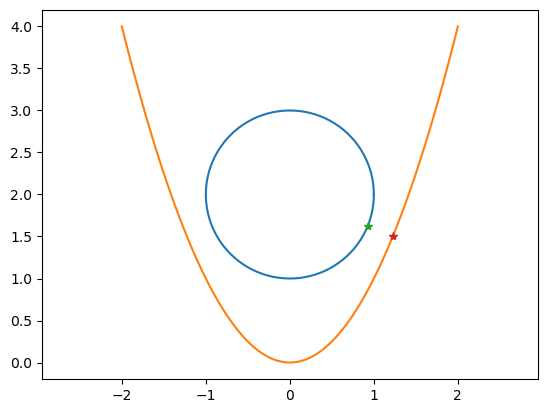

In [ ]:
import matplotlib.pyplot as plt
prog = MathematicalProgram()
p1 = prog.NewContinuousVariables(2, "p1")
p2 = prog.NewContinuousVariables(2, "p2")

# Add the constraint that p1 is on the unit circle centered at (0, 2)
prog.AddConstraint(
    lambda z: [z[0]**2 + (z[1]-2)**2],
    lb=np.array([1.]),
    ub=np.array([1.]),
    vars=p1)

# Add the constraint that p2 is on the curve y=x*x
prog.AddConstraint(
    lambda z: [z[1] - z[0]**2],
    lb=[0.],
    ub=[0.],
    vars=p2)

# Add the cost on the distance between p1 and p2
prog.AddQuadraticCost((p1-p2).dot(p1-p2))

# Set the value of p1 in initial guess to be [0, 1]
prog.SetInitialGuess(p1, [0., 1.])
# Set the value of p2 in initial guess to be [1, 1]
prog.SetInitialGuess(p2, [1., 1.])

# Now solve the program
result = Solve(prog)
print(f"Is optimization successful? {result.is_success()}")
p1_sol = result.GetSolution(p1)
p2_sol = result.GetSolution(p2)
print(f"solution to p1 {p1_sol}")
print(f"solution to p2 {p2_sol}")
print(f"optimal cost {result.get_optimal_cost()}")

# Plot the solution.
plt.figure()
plt.plot(np.cos(np.linspace(0, 2*np.pi, 100)), 2+np.sin(np.linspace(0, 2*np.pi, 100)))
plt.plot(np.linspace(-2, 2, 100), np.power(np.linspace(-2, 2, 100), 2))
plt.plot(p1_sol[0], p1_sol[1], '*')
plt.plot(p2_sol[0], p2_sol[1], '*')
plt.axis('equal')
plt.show()

<a style='text-decoration:none;line-height:16px;display:flex;color:#5B5B62;padding:10px;justify-content:end;' href='https://deepnote.com?utm_source=created-in-deepnote-cell&projectId=daec9c67-c271-4556-b3d6-020f0178ac09' target="_blank">
 </img>
Created in <span style='font-weight:600;margin-left:4px;'>Deepnote</span></a>